In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
dataset = pd.read_csv('C:\\Users\\hp\\Desktop\\Sem 5\\ML Assignments\\Assignment1\\PartB\\health care diabetes.csv')

In [3]:
Features = dataset.iloc[:, :8]
Target = dataset.iloc[:, 8:]

Features = Features.values
Target = Target.values


# Splitting into training, testing and validation

In [4]:
train_x = Features[:int(768*0.7), :]
train_y = Target[:int(768*0.7), :]
validation_x = Features[int(768*0.7): int(768*0.9), :]
validation_y = Target[int(768*0.7): int(768*0.9), :]
test_x = Features[int(768*0.9):, :]
test_y = Target[int(768*0.9):, :]

# **Part A**

In [17]:
class logisticRegression:
    def __init__(self, train_x, train_y, validation_x, validation_y, num_epochs, learningRate, regularization_type, lamda, batch_size = -1, activation = "sigmoid"):
        self.noOfSamples = train_x.shape[0]
        self.noOfFeatures = train_x.shape[1] + 1
        self.learningRate = learningRate
        self.regularization_type = regularization_type
        self.lamda = lamda
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.activation = activation
        self.Xis = train_x
        self.Yis = train_y
        self.Vxis = validation_x
        self.Vyis = validation_y

        self.trainingLoss = []
        self.validationLoss = []
        self.trainingAccuracy = []
        self.validationAccuracy = []

    def sigmoidFunction(self, x):
        return 1/(1 + np.exp(-x))
        
    def activationFunction(self, x):
        if self.activation == "sigmoid":
            return self.sigmoidFunction(x)
        elif self.activation == "tanh":
            return (np.tanh(x)+1)/2

    def update(self, Pis, tmp, x_batch):
        if self.activation == "sigmoid":
            if self.regularization_type == "L1":
                self.theta -= (self.learningRate)*(1/self.batch_size)*(np.dot(x_batch.transpose(), Pis - tmp) + self.lamda*np.sign(self.theta))
            elif self.regularization_type == "L2":
                self.theta -= (self.learningRate)*(1/self.batch_size)*(np.dot(x_batch.transpose(), Pis - tmp) + 2*self.lamda*self.theta)
            else:
                self.theta = self.theta - (self.learningRate)*(1/self.batch_size)*(np.dot(x_batch.transpose(), Pis - tmp))
        elif self.activation == "tanh":
            if self.regularization_type == "L1":
                self.theta -= (self.learningRate)*(1/self.batch_size)*(np.dot(x_batch.transpose(), (Pis -tmp)*(1-Pis**2)) + self.lamda*np.sign(self.theta))
            elif self.regularization_type == "L2":
                self.theta -= (self.learningRate)*(1/self.batch_size)*(np.dot(x_batch.transpose(), (Pis -tmp)*(1-Pis**2)) + 2*self.lamda*self.theta)
            else:
                self.theta = self.theta - (self.learningRate)*(1/self.batch_size)*(np.dot(x_batch.transpose(),(Pis -tmp)*(1-Pis**2)))

    def calculate_loss(self, true_labels, predicted_values):
        epsilon = 1e-15  
        predicted_values = np.clip(predicted_values, epsilon, 1 - epsilon)
        normal_loss  = 0
        if self.activation == "sigmoid":
            normal_loss = -np.mean(true_labels*np.log(predicted_values) + (1 - true_labels)*np.log(1 - predicted_values))
        elif self.activation == "tanh":
            normal_loss = np.mean((true_labels-predicted_values)**2)

        if self.regularization_type == "L1":
            return normal_loss +  self.lamda*np.sum(np.abs(self.theta))
        elif self.regularization_type == "L2":
            print(normal_loss,  self.lamda*np.sum(self.theta**2))
            return normal_loss +  self.lamda*np.sum(self.theta**2)       
        else:
            return normal_loss

    def pre_processing(self):
        # Scaling and adding bias
        X0s = np.ones((self.noOfSamples,1))
        self.Xis = np.array(self.Xis)
        Xmean = self.Xis.mean(axis=0)
        Xstd = self.Xis.std(axis=0)
        for z in range(self.Xis.shape[0]):
            self.Xis[z] = (self.Xis[z]-Xmean)/Xstd
        self.Xis = np.concatenate((X0s, self.Xis), axis=1)

        Vx0s = np.ones((self.Vxis.shape[0],1))
        self.Vxis = np.array(self.Vxis)
        Vxmean = self.Vxis.mean(axis=0)
        Vxstd = self.Vxis.std(axis=0)
        for z in range(self.Vxis.shape[0]):
            self.Vxis[z] = (self.Vxis[z]-Vxmean)/Vxstd
        self.Vxis = np.concatenate((Vx0s, self.Vxis), axis=1)

    def train(self):
        self.pre_processing()
        # self.theta = np.zeros(self.noOfFeatures)
        self.theta = np.random.rand(self.noOfFeatures)
        # Normalise your data
        for i in range(self.num_epochs):
            print("Epoch --- ", i)
            if(self.batch_size == -1):
               self.batch_size = 1
            num_of_batches =  self.noOfSamples//self.batch_size
            shuffle = np.random.permutation(self.noOfSamples)
            x_random = self.Xis[shuffle]
            y_random = self.Yis[shuffle]
            epoch_training_loss = 0
            for batch_id in range(num_of_batches):
                x_batch = x_random[batch_id*self.batch_size : (batch_id + 1)*self.batch_size]
                y_batch = y_random[batch_id*self.batch_size : (batch_id + 1)*self.batch_size]
                predicted_values = self.activationFunction(np.dot(x_batch, self.theta))
                if(self.batch_size == 1):
                    if(predicted_values[0] == 1):
                        predicted_values[0] -= (1e-7)
                    if(predicted_values[0] == 0):
                        predicted_values[0] += (1e-7)
                self.update(predicted_values, y_batch, x_batch)


            # Calculating training loss an accuracy
            predicted_values = self.activationFunction(np.dot(x_random, self.theta))
            predicted_labels = (predicted_values > 0.5).astype(int)
            epoch_training_loss = self.calculate_loss(y_random, predicted_values)
            self.trainingLoss.append(epoch_training_loss)
            self.trainingAccuracy.append(accuracy_score(y_random, predicted_labels))

            # Calculating validation loss and accuracy
            predicted_vvalues = self.activationFunction(np.dot(self.Vxis, self.theta))
            predicted_vlabels = (predicted_vvalues > 0.5).astype(int)
            epoch_validation_loss = self.calculate_loss(self.Vyis, predicted_vvalues)
            self.validationLoss.append(epoch_validation_loss)
            self.validationAccuracy.append(accuracy_score(self.Vyis, predicted_vlabels))
            print("trainingLoss : ", epoch_training_loss, "validationLoss : ", epoch_validation_loss, "trainingAccuracy :  ", accuracy_score(y_random, predicted_labels), " validationAccuracy : ",accuracy_score(self.Vyis, predicted_vlabels))

    def predict(self, test_x):              
        X0s = np.ones((test_x.shape[0],1))
        Xmean = test_x.mean(axis=0)
        Xstd = test_x.std(axis=0)
        for z in range(test_x.shape[0]):
            test_x[z] = (test_x[z]-Xmean)/Xstd
        test_x = np.concatenate((X0s, test_x), axis=1)

        predictedPis = []

        for z in test_x:
            predictedPis.append(self.activationFunction(np.matmul(z, self.theta)))
        predYis = []
        predYis = [0 if Pi < 0.5 else 1 for Pi in predictedPis]
        
        return np.array(predYis)
    
    def calculateAccuracy(self, dataSet, testingDataLabels):
        predY = self.predict(dataSet)
        print("Accurracy obtained is ", accuracy_score(testingDataLabels, predY))

In [6]:
train_y = train_y.reshape(train_y.shape[0])
validation_y = validation_y.reshape(validation_y.shape[0])

In [7]:
def plot_loss(model):
    xis = range(1, len(model.trainingLoss)+1)
    plt.xlabel("No of epochs")
    plt.ylabel("Loss")
    plt.plot(xis, model.trainingLoss, label = "training loss")
    plt.plot(xis, model.validationLoss, label = "validation loss")
    plt.legend()
    plt.show()

    plt.xlabel("No of epochs")
    plt.ylabel("Accuracy")
    plt.plot(xis, model.trainingAccuracy, color = "red", label = "training accuracy")
    plt.plot(xis, model.validationAccuracy, color = "black", label = "validation accuracy")
    plt.legend()
    plt.show()

# **Part B**

In [15]:
model_1 = logisticRegression(train_x, train_y, validation_x, validation_y, num_epochs = 500, learningRate=  1, regularization_type = "", lamda = 0, batch_size= -1)
model_1.train()


Epoch ---  0
trainingLoss :  1.1805963456518336 validationLoss :  0.8108808520469596 trainingAccuracy :   0.7337057728119181  validationAccuracy :  0.7597402597402597
Epoch ---  1
trainingLoss :  1.0074839123809567 validationLoss :  0.7983015777083519 trainingAccuracy :   0.7374301675977654  validationAccuracy :  0.7662337662337663
Epoch ---  2
trainingLoss :  0.9605998956988396 validationLoss :  0.7181733973582521 trainingAccuracy :   0.7169459962756052  validationAccuracy :  0.7662337662337663
Epoch ---  3
trainingLoss :  1.4674607338970231 validationLoss :  1.3919026084397894 trainingAccuracy :   0.6834264432029795  validationAccuracy :  0.6948051948051948
Epoch ---  4
trainingLoss :  1.5588492248247665 validationLoss :  1.5766261393721057 trainingAccuracy :   0.659217877094972  validationAccuracy :  0.6688311688311688
Epoch ---  5
trainingLoss :  1.6315889437311513 validationLoss :  1.4949054391521863 trainingAccuracy :   0.5996275605214153  validationAccuracy :  0.6493506493506493

In [231]:
model_01 = logisticRegression(train_x, train_y, validation_x, validation_y,  num_epochs = 800, learningRate=  0.1, regularization_type = "", lamda = 0, batch_size= -1)
model_01.train()

Epoch ---  0
trainingLoss :  0.533930106856987 validationLoss :  0.46341884276611595 trainingAccuracy :   0.7672253258845437  validationAccuracy :  0.7532467532467533
Epoch ---  1
trainingLoss :  0.5102875349601936 validationLoss :  0.40584371537767416 trainingAccuracy :   0.7560521415270018  validationAccuracy :  0.7987012987012987
Epoch ---  2
trainingLoss :  0.4950292809868322 validationLoss :  0.42624021760157477 trainingAccuracy :   0.7616387337057728  validationAccuracy :  0.8181818181818182
Epoch ---  3
trainingLoss :  0.5312044658275454 validationLoss :  0.4456960202903686 trainingAccuracy :   0.7635009310986964  validationAccuracy :  0.7727272727272727
Epoch ---  4
trainingLoss :  0.5005065334517883 validationLoss :  0.43387121771573095 trainingAccuracy :   0.7690875232774674  validationAccuracy :  0.8181818181818182
Epoch ---  5
trainingLoss :  0.5170907760091051 validationLoss :  0.43954346926328053 trainingAccuracy :   0.74487895716946  validationAccuracy :  0.7987012987012

In [18]:
model_001 = logisticRegression(train_x, train_y, validation_x, validation_y,  num_epochs = 1000, learningRate=  0.05, regularization_type = "", lamda = 0, batch_size= -1)
model_001.train()

Epoch ---  0
trainingLoss :  0.4986528535459953 validationLoss :  0.4259887108610262 trainingAccuracy :   0.750465549348231  validationAccuracy :  0.8181818181818182
Epoch ---  1
trainingLoss :  0.5005355701872098 validationLoss :  0.42753029583978197 trainingAccuracy :   0.7839851024208566  validationAccuracy :  0.7727272727272727
Epoch ---  2
trainingLoss :  0.5034776694667465 validationLoss :  0.43065617180741733 trainingAccuracy :   0.7690875232774674  validationAccuracy :  0.8051948051948052
Epoch ---  3
trainingLoss :  0.49147586997056836 validationLoss :  0.4078864383816117 trainingAccuracy :   0.7746741154562383  validationAccuracy :  0.7987012987012987
Epoch ---  4
trainingLoss :  0.49103182590917616 validationLoss :  0.411715002472058 trainingAccuracy :   0.7672253258845437  validationAccuracy :  0.7922077922077922
Epoch ---  5
trainingLoss :  0.4903961727807199 validationLoss :  0.41265226604913796 trainingAccuracy :   0.7728119180633147  validationAccuracy :  0.824675324675

In [9]:
model_0001 = logisticRegression(train_x, train_y, validation_x, validation_y, num_epochs = 500, learningRate=  0.001, regularization_type = "", lamda = 0, batch_size= -1, activation= "tanh")
model_0001.train()

Epoch ---  0
trainingLoss :  0.3083289034852762 validationLoss :  0.3087264462612981 trainingAccuracy :   0.590316573556797  validationAccuracy :  0.6038961038961039
Epoch ---  1
trainingLoss :  0.30129490208800064 validationLoss :  0.2996169190923316 trainingAccuracy :   0.6070763500931099  validationAccuracy :  0.6168831168831169
Epoch ---  2
trainingLoss :  0.2948743112479748 validationLoss :  0.29130027360853805 trainingAccuracy :   0.6219739292364991  validationAccuracy :  0.6363636363636364
Epoch ---  3
trainingLoss :  0.28904273925649443 validationLoss :  0.2837839896782903 trainingAccuracy :   0.6256983240223464  validationAccuracy :  0.6493506493506493
Epoch ---  4
trainingLoss :  0.283677191637728 validationLoss :  0.27692168564770325 trainingAccuracy :   0.6350093109869647  validationAccuracy :  0.6623376623376623
Epoch ---  5
trainingLoss :  0.27868348496530404 validationLoss :  0.270600306607048 trainingAccuracy :   0.6424581005586593  validationAccuracy :  0.6753246753246

KeyboardInterrupt: 

# **Part C**

In [14]:
def metrics(true_y, predicted_y):
   confusion_matrix = np.zeros((2, 2))
    # Actual
   for i in range(true_y.shape[0]):
       confusion_matrix[true_y[i], predicted_y[i]] += 1 
   print("Confusion Matrix : ", confusion_matrix)
   
   TrueNegative =  confusion_matrix[0, 0]
   FalsePositive = confusion_matrix[0, 1]
   FalseNegative = confusion_matrix[1, 0]
   TruePositive = confusion_matrix[1, 1]
   print("True negative is : ", TrueNegative)
   print("False positive is : ", FalsePositive)
   print("False negative is : ", FalseNegative)
   print("True positive is : ", TruePositive)
   recall = TruePositive/(TruePositive + FalseNegative)
   precision = TruePositive/(TruePositive + FalsePositive) 

   print("Recall is  : ", recall)
   print("Precision is : ", precision)
   print("F1 score is : ", (2*precision*recall)/(precision+ recall))
   print("Accurracy obtained is ", accuracy_score(true_y, predicted_y))


In [15]:
print("Model with learning rate 1 ")
metrics(test_y, model_1.predict(test_x))
plot_loss(model_1)

Model with learning rate 1 


NameError: name 'model_1' is not defined

Model with learning rate 0.1 
Confusion Matrix :  [[42.  4.]
 [14. 17.]]
True negative is :  42.0
False positive is :  4.0
False negative is :  14.0
True positive is :  17.0
Recall is  :  0.5483870967741935
Precision is :  0.8095238095238095
F1 score is :  0.6538461538461537
Accurracy obtained is  0.7662337662337663


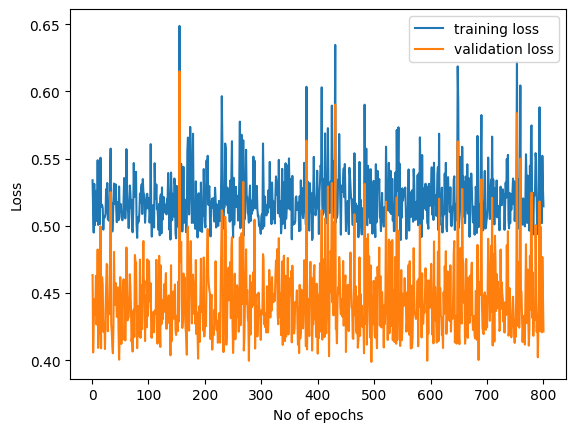

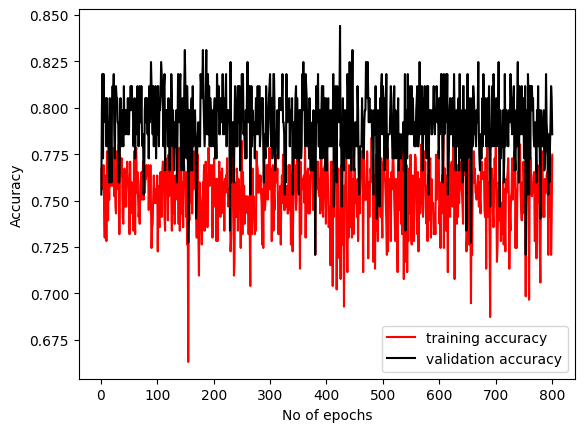

In [236]:
print("Model with learning rate 0.1 ")
metrics(test_y, model_01.predict(test_x))
plot_loss(model_01)

Model with learning rate 0.01 
Confusion Matrix :  [[42.  4.]
 [13. 18.]]
True negative is :  42.0
False positive is :  4.0
False negative is :  13.0
True positive is :  18.0
Recall is  :  0.5806451612903226
Precision is :  0.8181818181818182
F1 score is :  0.679245283018868
Accurracy obtained is  0.7792207792207793


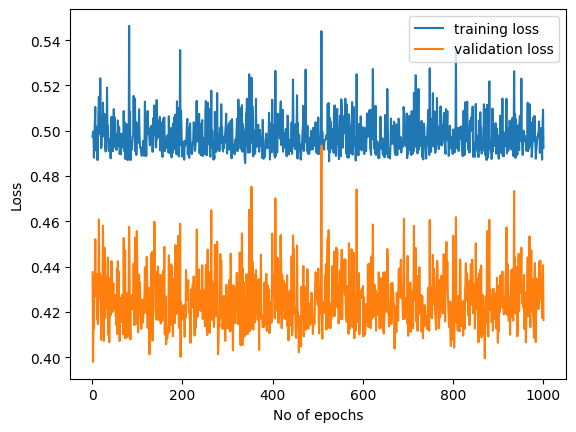

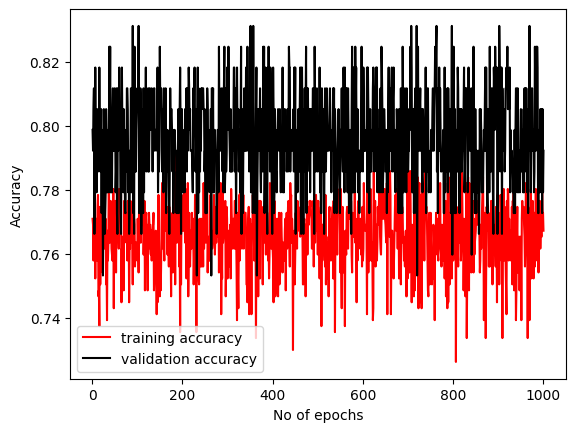

In [16]:
print("Model with learning rate 0.01 ")
metrics(test_y, model_001.predict(test_x))
plot_loss(model_001)

Model with learning rate 0.001 
Confusion Matrix :  [[43.  3.]
 [13. 18.]]
True negative is :  43.0
False positive is :  3.0
False negative is :  13.0
True positive is :  18.0
Recall is  :  0.5806451612903226
Precision is :  0.8571428571428571
F1 score is :  0.6923076923076923
Accurracy obtained is  0.7922077922077922


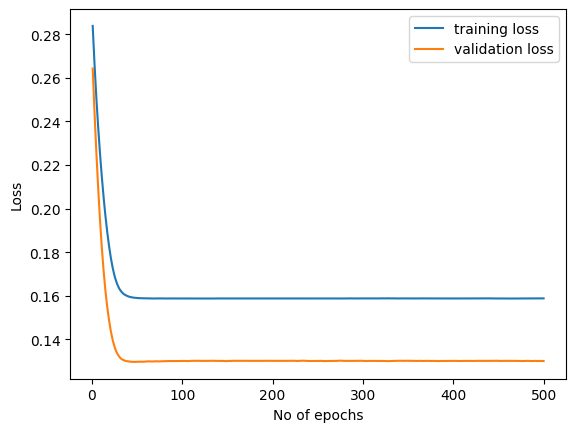

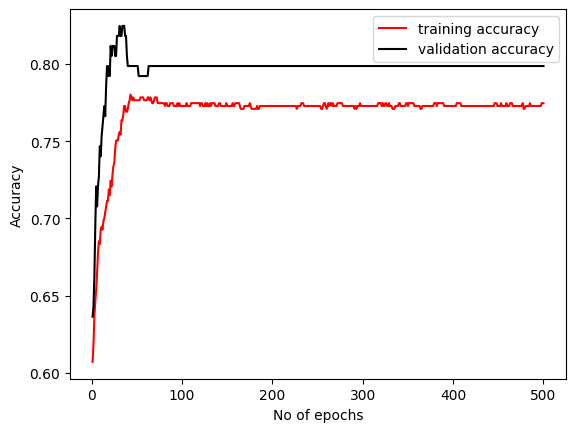

In [23]:
print("Model with learning rate 0.001 ")
metrics(test_y, model_0001.predict(test_x))
plot_loss(model_0001)

# **Part F**

In [12]:
model_batch_001 = logisticRegression(train_x, train_y, validation_x, validation_y,  num_epochs = 600, learningRate=  0.001, regularization_type = "L1", lamda = 0.01, batch_size = -1)
model_batch_001.train()

Epoch ---  0
trainingLoss :  0.7678582217171437 validationLoss :  0.7533408705969489 trainingAccuracy :   0.6461824953445066  validationAccuracy :  0.6558441558441559
Epoch ---  1
trainingLoss :  0.7286670603740865 validationLoss :  0.7112939734477715 trainingAccuracy :   0.6536312849162011  validationAccuracy :  0.6753246753246753
Epoch ---  2
trainingLoss :  0.6964230509407018 validationLoss :  0.6766581839864629 trainingAccuracy :   0.6722532588454376  validationAccuracy :  0.6818181818181818
Epoch ---  3
trainingLoss :  0.6683121572630574 validationLoss :  0.6462836114068524 trainingAccuracy :   0.6890130353817505  validationAccuracy :  0.7012987012987013
Epoch ---  4
trainingLoss :  0.6442565761524046 validationLoss :  0.6200595947229994 trainingAccuracy :   0.7001862197392924  validationAccuracy :  0.7077922077922078
Epoch ---  5
trainingLoss :  0.6246695255920135 validationLoss :  0.5983148447233527 trainingAccuracy :   0.7094972067039106  validationAccuracy :  0.720779220779220

Confusion Matrix :  [[44.  2.]
 [13. 18.]]
True negative is :  44.0
False positive is :  2.0
False negative is :  13.0
True positive is :  18.0
Recall is  :  0.5806451612903226
Precision is :  0.9
F1 score is :  0.7058823529411764
Accurracy obtained is  0.8051948051948052


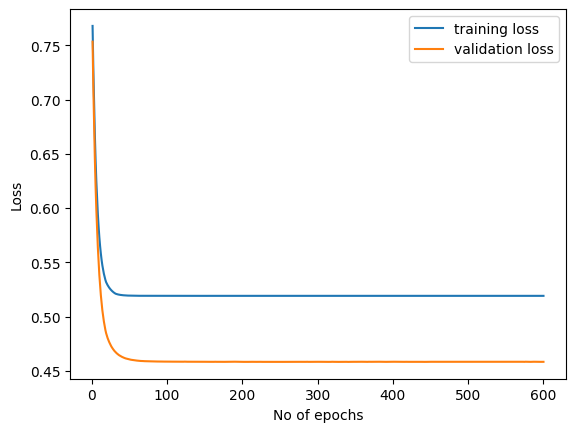

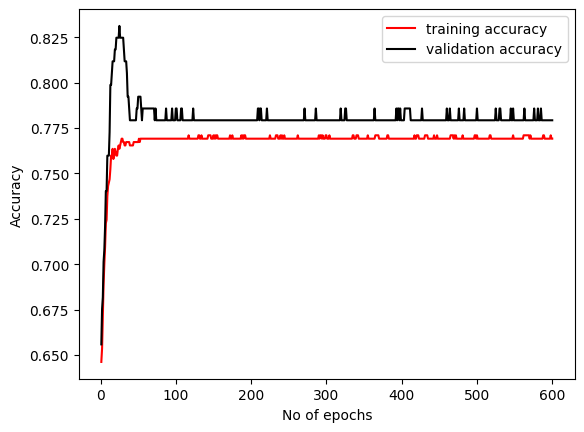

In [13]:
metrics(test_y, model_batch_001.predict(test_x))
plot_loss(model_batch_001)